In [1]:
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cProfile
import pstats
%load_ext line_profiler

--------

### Set the number of resources

In [4]:
L = 40

### Define the ancestral phenotype (traits vector)

In [5]:
anc_phenotype = utils.random_matrix(shape=(1, L), mode='binomial')

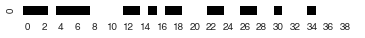

In [6]:
viz.matrix_plot(anc_phenotype)

### Define the system biochemistry (trait/resource interactions)

In [7]:
J = utils.random_matrix((L, L), 'tikhonov_sigmoid')

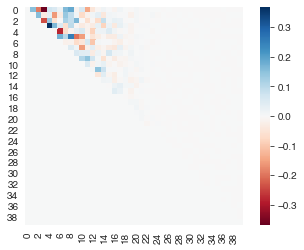

In [8]:
viz.matrix_plot(J)

### Parameterize and instantiate the Consumer-Resource System

In [9]:
anc_system = ConsumerResourceSystem(sigma=anc_phenotype, 
                                    b=1, 
                                    k=1e10,
                                    c=0.1, chi=0.5, J=J, 
                                    mu=1e-10,
                                    resource_consumption_mode='fast_resource_eq',
                                    resource_inflow_mode='none',
                                    threshold_min_rel_abundance=1e-6,
                                    N_init=1, R_init=1)

### Simulate dynamics

In [10]:
# just to pre-compile the dynamics njit function
# anc_system.dynamics(*((0,) + (np.zeros(L+L+1),) + anc_system.get_params()))

In [11]:
# anc_system.run(T=1000)

In [12]:
# %lprun -f anc_system.dynamics anc_system.run(T=1000)
# %lprun -f anc_system.handle_mutation_event anc_system.run(T=1000)

In [13]:
profiler = cProfile.Profile()
# %lprun -f anc_system.dynamics profiler.runcall(anc_system.run)
# %lprun -f ConsumerResourceSystem.growth_rate profile.runcall(anc_system.run)
# %lprun -f anc_system.event_low_abundance profiler.runcall(anc_system.run)
# %lprun -f TypeSet.add_type profiler.runcall(anc_system.run)
# %lprun -f TypeSet.generate_mutant_set profiler.runcall(anc_system.run)

%lprun -f anc_system.run profiler.runcall(anc_system.run)

Timer unit: 1e-06 s

Total time: 1593.89 s
File: /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py
Function: run at line 181

Line #      Hits         Time  Per Hit   % Time  Line Contents
   181                                               def run(self, T=1000, dt=None, integration_method='default'):
   182                                           
   183         1          5.0      5.0      0.0          t_start   = self.t
   184         1          2.0      2.0      0.0          t_elapsed = 0
   185                                           
   186      5699      15742.0      2.8      0.0          while(t_elapsed < T):
   187                                           
   188                                                       #------------------------------
   189                                                       # Set initial conditions and integration variables:
   190                                                

In [14]:
ps = pstats.Stats(profiler)
ps.sort_stats('cumtime')
ps.print_stats()

         11827698 function calls (11825034 primitive calls) in 1594.358 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   92.700   92.700 1594.358 1594.358 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:181(run)
   132019  684.521    0.005  684.521    0.005 {built-in method numpy.concatenate}
    11396    0.127    0.000  675.066    0.059 /usr/local/lib/python3.8/site-packages/numpy/core/shape_base.py:285(hstack)
     5698    1.165    0.000  666.313    0.117 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:473(handle_mutation_event)
     2651   46.651    0.018  626.793    0.236 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:619(add_type)
   233288  487.958    0.002  522.907    0.002 /usr/local/lib/python3.8/site-packages/numpy/li

### Visualize results

In [15]:
type_colors = viz.color_types_by_phylogeny(anc_system.type_set, apply_palette_depth=1)

<AxesSubplot:>

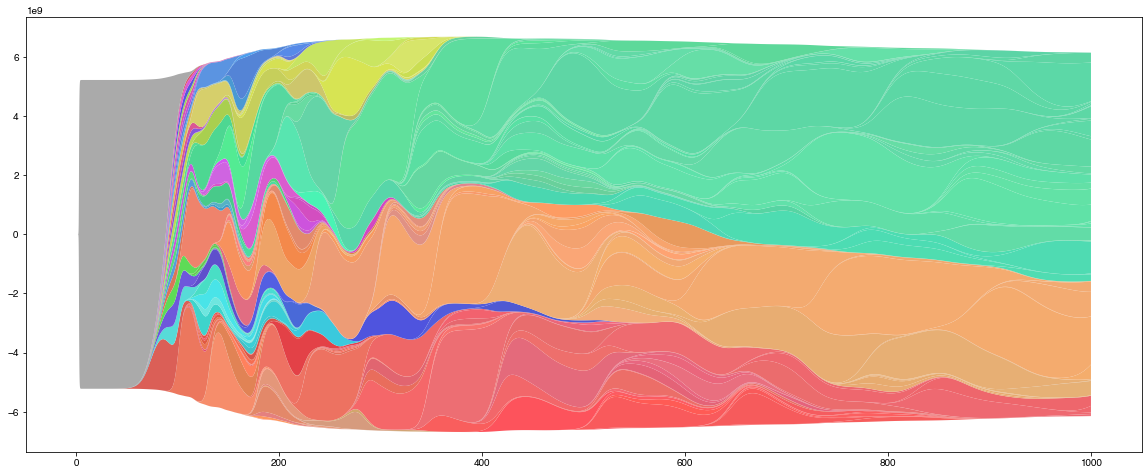

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(anc_system, ax=ax, type_colors=type_colors)

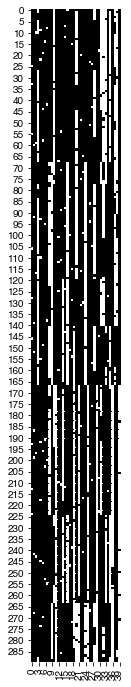

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.get_extant_type_set().sigma, ax=ax)

In [18]:
anc_system.type_set.mutant_set.sigma.shape

(106080, 40)

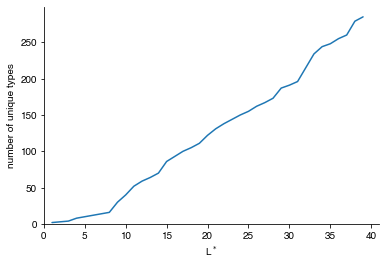

In [19]:
viz.Lstar_types_plot(anc_system)

In [20]:
N_end = anc_system.N_series[:,-1]
np.count_nonzero((N_end > 0) & (N_end < 1e4))

126

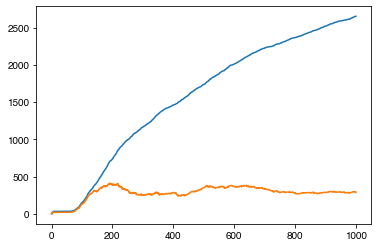

In [21]:
a = (anc_system.N_series > 0).argmax(axis=1)
n = []
for t_idx in range(anc_system.t_series.shape[0]):
    n.append(np.count_nonzero(a <= t_idx)) 
plt.plot(anc_system.t_series, n)
plt.plot(anc_system.t_series, (anc_system.N_series > 0).sum(axis=0))

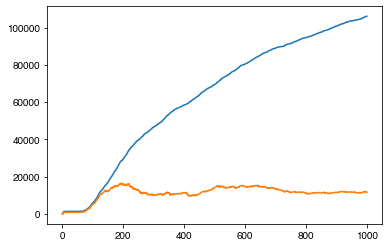

In [34]:
plt.plot(anc_system.t_series, np.array(n)*40)
plt.plot(anc_system.t_series, (anc_system.N_series > 0).sum(axis=0)*40)

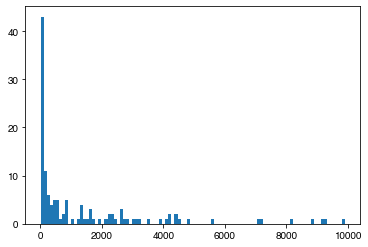

In [39]:
plt.hist(anc_system.N_series[(anc_system.N_series[:,-1]>0)&(anc_system.N_series[:,-1]<1e4),-1], bins=100)
# plt.xlim((0,100))
plt.show()

In [24]:
r = ConsumerResourceSystem.growth_rate(anc_system.N()[:, np.newaxis], anc_system.R(), anc_system.type_set.sigma, anc_system.type_set.b, anc_system.type_set.k, anc_system.type_set.eta, anc_system.type_set.l, anc_system.type_set.g, anc_system.type_set.energy_costs, anc_system.resource_set.omega, anc_system.resource_consumption_mode)

In [41]:
r[(anc_system.N() > 0) & (anc_system.N() < 1e4)] - np.mean(r[r > 0])

array([-0.00586797, -0.00586856, -0.005872  , -0.0077336 ,  0.04548767,
       -0.00772978, -0.00773394,  0.02576726,  0.04866208, -0.00773263,
       -0.00774587, -0.00773328,  0.03133008, -0.00773763, -0.0077297 ,
       -0.00774019, -0.00773298, -0.04847264,  0.01607495,  0.02074814,
        0.05980792,  0.0739655 , -0.00801339, -0.00800902, -0.00800957,
        0.0447494 ,  0.04522015,  0.03386653,  0.0158109 , -0.00800051,
       -0.00799843,  0.00085144,  0.00084984,  0.01295739, -0.02463739,
        0.0431185 ,  0.03045611,  0.04757626, -0.01140764,  0.00357639,
       -0.01141154,  0.00124241,  0.00124682,  0.00125475,  0.00125467,
        0.00125085,  0.01335901, -0.00385578, -0.01608773, -0.01608052,
       -0.00861206, -0.01608518, -0.01607893, -0.01607846, -0.0023257 ,
       -0.00232301,  0.03927443, -0.002323  , -0.00232507, -0.00232604,
       -0.00232509, -0.00232538,  0.00978246, -0.00618921, -0.00618955,
        0.04656035,  0.00127891, -0.00620244,  0.00603519, -0.00

In [26]:
r[r<0]

array([-0.73039147, -0.9742608 , -0.9407559 , ..., -0.72124711,
       -0.65696211, -0.73206508])

In [27]:
anc_system.type_set.sigma.shape

(2652, 40)

In [28]:
a = np.where(anc_system.N_series > 0)

In [29]:
anc_system.get_extant_types()


array([ 566,  589,  592,  595,  597,  600,  603,  604,  605,  606,  607,
        608,  609,  610,  611,  612,  613,  614,  615,  616,  617,  618,
        619,  620,  621,  622,  623,  625,  626,  628,  630,  632,  636,
        637,  643,  647,  648,  652,  653,  654,  655,  656,  657,  658,
        659,  660,  669,  671,  673,  674,  676,  677,  678,  679,  680,
        681,  682,  683,  684,  685,  686,  687,  688,  689,  690,  691,
        692,  693,  794,  797,  799,  800,  801,  802,  803,  804,  806,
        810,  846,  847,  858,  859,  860,  861,  863,  864,  865,  866,
        867,  868,  869,  875,  876,  877,  878,  879,  880,  881,  882,
        883,  884,  885,  886,  887,  888,  889,  890,  891,  892,  893,
        894,  895,  896,  897,  898,  899,  900,  901,  902,  903,  933,
        935,  939,  943,  944,  945,  946,  947,  948,  949,  950,  951,
        952,  953,  954,  955,  956,  957,  958,  959,  960, 1093, 1095,
       1099, 1100, 1101, 1102, 1103, 1104, 1105, 11

In [30]:
1e3/1e10

1e-07

In [31]:
anc_system.type_set.mu.shape

()

In [42]:
anc_system.t_series.shape

(28846,)

In [43]:
anc_system.N_series.shape

(2652, 28846)

In [44]:
anc_system.type_set.mutant_set.num_types

106080